# Лабораторная работа №0

## Выгрузка данных

Разархивируем данные:

In [1]:
!tar -xzvf data/bank_data_1.tar.gz

выгрузка.csv


Для удобства (чтобы исключить кириллицу в частности) переименуем файл:

In [2]:
!mv выгрузка.csv data.csv

Опять же для удобства создаем простую обертку над collections.OrderedDict представляющую собой структуру с методами для импорта и экспорта в CSV.

In [3]:
import csv

from typing import List, Iterable
from collections import OrderedDict


def transpose(l: List[List]):
    return map(list, zip(*l))


def as_type(it: Iterable, t):
    return map(lambda x: t(x) if x else t(), it)


class Table:
    def __init__(self, columns: List,
                 lines: List[List],
                 transposed=False):
        self.data = OrderedDict(zip(columns,
                                    transpose(lines)
                                    if not transposed
                                    else lines))
                
    def to_csv(self, filename, **kwargs):
        with open(filename, 'w', newline='') as file:
            csvfile = csv.writer(file, **kwargs)
            csvfile.writerow(self.data.keys())
            csvfile.writerows(transpose(col for col in self.data.values()))
    
    @staticmethod
    def from_csv(filename, **kwargs):
        with open(filename, 'r', newline='') as file:
            csvfile = csv.reader(file, **kwargs)
            try: columns = next(csvfile)
            except StopIteration: raise RuntimeError("File is empty")
            return Table(columns, list(csvfile))

Заранее загрузим данные в таблицу и выведем названия стобцов:

In [4]:
table = Table.from_csv('data.csv', delimiter=';')
print(f"Columns: {', '.join(table.data.keys())}.")

Columns: EVENT_TIME, USER_HASH, EVENT_TYPE, EVENT_TYPE_EX, AMOUNT, X2, X3, X4, X5, X6, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X22, X23, X24, X26, COOKIE, p1_Fraud, p2_Fraud, p3_Fraud, p4_Fraud, p5_Fraud.


Не хватает последней колонки 'CLASS'. Поскольку колонка последняя, то первая мысль - на zip в функции transpose. Zip останавливается как только исчерпана кратчайшая из входных последовательностей, а в случае transpose - zip проходится по рядам. Подтвердим догадку:

In [5]:
rows = dict()

with open('data.csv', 'r', newline='') as file:
    csvfile = csv.reader(file, delimiter=';')
    columns = len(next(csvfile))
    for idx, row in enumerate(csvfile):
        if len(row) == columns: continue
        print(f"Row: {idx}, contents: {row}")
        rows[idx] = row

Row: 12312, contents: ['2015-12-23 12:48:4735b2fc6cadb85070f2768831155a1f8e5124', 'PAYMENT', 'RURPAYJURSB', '100', '1971-02-21 00:00:00', 'a364-:3f6b6dec151:ec909932', 'a12b9d3119', '9b2f19e9e1', 'a9ba90c127', '0', '0', 'Windows', 'RUB', '911', '0', '1194', 'Chrome::47', '1599', '898', '3.0', '217.118.81.195', 'Krasnodar', '/PhizIC/private/async/payments/confirm.do', '156350213', '0.6900', '0.7900', '0.5400', '0.5300', '0.9900', 'G']


Считаем файл и сохраним исправленное содержимое в другой файл:

In [6]:
idx = 12312
rows[idx] = ['2015-12-23 12:48:47', '35b2fc6cadb85070f2768831155a1f8e5124'] + rows[idx][1:]

with open('data.csv', 'r', newline='') as inp:
    csvfile = csv.reader(inp, delimiter=';')
    data = list(csvfile)
    data[idx + 1] = rows[idx]
    with open('fixed_data.csv', 'w', newline='') as outp:
        csvfile = csv.writer(outp, delimiter=';')
        csvfile.writerows(data)

Пересоздаем таблицу, над которой будем работать:

In [7]:
table = Table.from_csv('fixed_data.csv', delimiter=';')
print(f"Columns: {', '.join(table.data.keys())}.")

Columns: EVENT_TIME, USER_HASH, EVENT_TYPE, EVENT_TYPE_EX, AMOUNT, X2, X3, X4, X5, X6, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X22, X23, X24, X26, COOKIE, p1_Fraud, p2_Fraud, p3_Fraud, p4_Fraud, p5_Fraud, CLASS.


Визуализируем распределение легитимных/мошеннических/прочих операций:

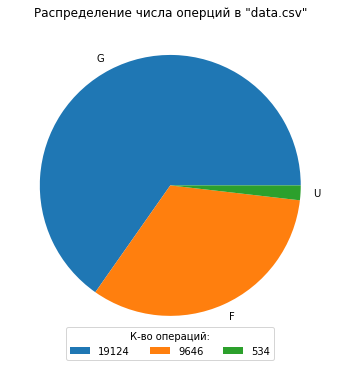

In [8]:
import matplotlib.pyplot as plt 

from collections import Counter


counts = Counter([c if c in ['F', 'G', 'U'] else 'O' for c in table.data['CLASS']])
plt.figure(figsize=(6, 6))
plt.title('Распределение числа оперций в "data.csv"')
plt.pie(counts.values(), labels=counts.keys())
plt.legend(counts.values(),
           title='К-во операций:',
           loc='lower center',
           bbox_to_anchor=(0.5, -0.05),
           ncol=3)
plt.show()

## Задание 1

Полнота (Recall):
$$П = P(F_s|F_r) = \frac{C(F_sF_r)}{C(F_sF_r) + C(L_sF_r)}$$

Точность (Precision):
$$Т = P(F_r|F_s) = \frac{C(F_sF_r)}{C(F_sF_r) + q C(F_sL_r)}$$

В данных формулах $C(AB)$ - количество операций, соответствующих событию $AB$, а $\frac{1}{q}$ - доля, которую составляет выборка легитимных операций от общего числа операций.

Преобразуем исходную таблицу.
Для начала отфильтруем невалидные данные (строки с меткой 'U' в частности):

In [9]:
columns = ['AMOUNT', 'p1_Fraud', 'p2_Fraud', 'p3_Fraud', 'p4_Fraud', 'p5_Fraud', 'CLASS']
data = [table.data[col] for col in columns]
valid_idx = {idx for idx, elem in enumerate(data[-1]) if elem != 'U'}
data = [[elem for idx, elem in enumerate(col) if idx in valid_idx] for col in data]

Затем представим нужные столбцы в виде float и приведем столбец 'CLASS' к int, заменив F-метки на 1 и G-метки на 0:

In [10]:
data = [list(as_type(col, float)) for col in data[:-1]] + [[1 if elem == 'F' else 0 for elem in data[-1]]]
table = Table(columns, data, transposed=True)

Добавим в указанные значения отсечки значения 0.0 и 1.0 - так кривые ROC и P-R не будут "оторваны" от точек (0, 0) и (1, 1) и сохраним значение Q:

In [11]:
Q = 10
cutoffs = [0.1 * i for i in range(10)] + [0.95, 0.99, 1.]
systems = columns[1:-1]

Определим полноту и точность:

In [12]:
def precision(tp: int, fp: int, defval: float = 0.):
    s = tp + fp
    if s: return tp / s
    else: return defval


def recall(tp: int, fn: int, defval: float = 0.):
    s = tp + fn
    if s: return tp / s
    else: return defval

Определим функцию, которая определяет число FP, FN, TP, TN, случаев исходя из ответов системы и действительных меток. Пусть она так же принимает вес операции - на тот случай, если понадобятся взвешенные значения полноты и точности.

In [13]:
from enum import IntEnum


class Label(IntEnum):
    TN = 0  # 0 0
    FN = 1  # 0 1
    FP = 2  # 1 0
    TP = 3  # 1 1


def factorTable(system, real, weights=None):
    counts = [0] * 4
    if weights is None:
        for s, r in zip(system, real):
            counts[s * 2 + r] += 1
    else:
        for s, r, w in zip(system, real, weights):
            counts[s * 2 + r] += w
    return counts

Далее встретятся и другие метрики, оперирующие FactorTable. Напишем унифицированную функцию, позволяющую посчитать любую из них, а так же обертку - конкретно для полноты и точности:

In [14]:
def threshold(threshold=0.5):
    return lambda x: 0 if x < threshold else 1


def recl_prec(ft, q):
    return (recall(ft[Label.TP], ft[Label.FN]),
            precision(ft[Label.TP], q * ft[Label.FP]))


def describe_system(func, scores, real, cutoffs, weights=None, *args, **kwargs):
    fts = (factorTable(map(threshold(cut), scores), real, weights) for cut in cutoffs)
    return [func(ft, *args, **kwargs) for ft in fts]


def prec_recl_descr(name, *args, **kwargs):
    row_names = (f"{name} recall", f"{name} precision")
    return list(transpose([row_names, *describe_system(recl_prec, *args, **kwargs)]))

Определим вспомогательную функцию, "разворачивающую" последовательности подобно оператору `*`, но которую можно будет использовать вместе с генераторами последовательностей. При `times=1` `unfold` работает аналогично упомянутому оператору.

In [15]:
from collections.abc import Iterable as AbcIterable

def unfold(it: Iterable, times=1):
    for i in it:
        if isinstance(i, AbcIterable) and times > 1:
            for j in unfold(i, times - 1): yield j
        else: yield i

Найдем полноту и точность для каждой из экспертных систем

In [16]:
ds = lambda s: prec_recl_descr(s, table.data[s], table.data['CLASS'],
                               cutoffs, q=Q)

rows = list(unfold(map(ds, systems), 2))

Костыльно выведем получившиеся значения:

In [17]:
def make_table(rows):
    for row in rows:
        n, *row = row
        print(str(n).ljust(18), end='')
        for fp in row: print(format(fp, '.2f').rjust(6), end='') 
        print()

make_table([['systems'] + cutoffs])
make_table(rows)

systems             0.00  0.10  0.20  0.30  0.40  0.50  0.60  0.70  0.80  0.90  0.95  0.99  1.00
p1_Fraud recall     1.00  0.98  0.90  0.75  0.58  0.27  0.26  0.00  0.00  0.00  0.00  0.00  0.00
p1_Fraud precision  0.05  0.06  0.06  0.06  0.06  0.03  0.04  0.00  0.00  0.00  0.00  0.00  0.00
p2_Fraud recall     1.00  1.00  0.98  0.92  0.86  0.72  0.64  0.56  0.00  0.00  0.00  0.00  0.00
p2_Fraud precision  0.05  0.05  0.06  0.07  0.07  0.08  0.08  0.08  0.33  0.00  0.00  0.00  0.00
p3_Fraud recall     1.00  0.98  0.96  0.94  0.90  0.84  0.76  0.66  0.58  0.29  0.00  0.00  0.00
p3_Fraud precision  0.05  0.06  0.07  0.08  0.09  0.12  1.00  1.00  1.00  1.00  0.00  0.00  0.00
p4_Fraud recall     1.00  1.00  1.00  0.95  0.82  0.56  0.04  0.04  0.04  0.04  0.04  0.02  0.00
p4_Fraud precision  0.05  0.05  0.05  0.07  0.08  0.08  0.06  0.06  0.06  0.06  0.06  0.08  1.00
p5_Fraud recall     1.00  0.98  0.96  0.95  0.92  0.87  0.82  0.71  0.64  0.56  0.47  0.30  0.00
p5_Fraud precision  0.05  0.06

## Задание 2

С учетом сумм операций формулы будут выглядеть так:

Полнота (Recall):
$$П = P(F_s|F_r) = \frac{W(F_sF_r)}{W(F_sF_r) + W(L_sF_r)}$$

Точность (Precision):
$$Т = P(F_r|F_s) = \frac{W(F_sF_r)}{W(F_sF_r) + q W(F_sL_r)}$$

В данных формулах $W(AB)$ - сумма всех операций, соответствующих событию $AB$, а $\frac{1}{q}$ - доля, которую составляет выборка легитимных операций от общего числа операций.

Выполним расчеты дополнительно указав колонку 'AMOUNT' для функции, находящей фактор-таблицу. Для этого нужно будет привести эту колонку к нужному типу:

In [18]:
wds = lambda s: prec_recl_descr(s, table.data[s], table.data['CLASS'],
                                cutoffs, table.data['AMOUNT'], q=Q)

wrows = list(unfold(map(wds, systems), 2))

make_table([['systems'] + cutoffs])
make_table(wrows)

systems             0.00  0.10  0.20  0.30  0.40  0.50  0.60  0.70  0.80  0.90  0.95  0.99  1.00
p1_Fraud recall     1.00  0.96  0.80  0.60  0.32  0.12  0.10  0.00  0.00  0.00  0.00  0.00  0.00
p1_Fraud precision  0.04  0.05  0.06  0.06  0.05  0.02  0.02  0.00  0.00  0.00  0.00  0.00  0.00
p2_Fraud recall     1.00  1.00  0.96  0.84  0.74  0.53  0.42  0.29  0.01  0.00  0.00  0.00  0.00
p2_Fraud precision  0.04  0.04  0.05  0.06  0.07  0.08  0.07  0.06  0.82  0.00  0.00  0.00  0.00
p3_Fraud recall     1.00  0.96  0.91  0.86  0.77  0.69  0.58  0.43  0.32  0.11  0.00  0.00  0.00
p3_Fraud precision  0.04  0.05  0.06  0.08  0.10  0.15  1.00  1.00  1.00  1.00  0.00  0.00  0.00
p4_Fraud recall     1.00  1.00  1.00  0.87  0.66  0.29  0.03  0.03  0.03  0.03  0.03  0.01  0.00
p4_Fraud precision  0.04  0.04  0.04  0.07  0.09  0.06  0.04  0.04  0.04  0.04  0.04  0.03  1.00
p5_Fraud recall     1.00  0.96  0.92  0.87  0.82  0.73  0.66  0.49  0.40  0.29  0.22  0.12  0.01
p5_Fraud precision  0.04  0.05

## Задание 3

Построим ROC-кривую для полученных данных

По вертикали True Positive Rate - в точности Полнота:

$$TPR = \frac{C(F_sF_r)}{C(F_sF_r) + C(L_sF_r}$$

По горизонтали False Positive Rate:

$$FPR = \frac{q C(F_sL_r)}{q C(F_sL_r) + q C(L_sL_r)} = \frac{C(F_sL_r)}{C(F_sL_r) + C(L_sL_r)}$$

Аналогично тому, как мы завышали количество FP-операций в $q$ раз поступим с TN-операциями. Это обуславливается тем, что TN-операции так же как и FP-операции связаны с "настоящими" легитимными операциями, число которых так или иначе занижается при составлении датасета. Таким образом, $q$ появляется как в числителе, так и в знаменателе и мы ее сокращаем.

Определяем TPR/FPR и функцию, считающую значения для ROC:

In [19]:
def tpr(tp, fn, defval=0.):
    s = tp + fn
    if s: return tp / s
    return defval


def fpr(fp, tn, defval=0.):
    s = fp + tn
    if s: return fp / s
    return defval


def fpr_tpr(ft):
    return (fpr(ft[Label.FP], ft[Label.TN]),
            tpr(ft[Label.TP], ft[Label.FN]))


def roc_descr(name, *args, **kwargs):
    row_names = (f"{name} FPR", f"{name} TPR")
    return list(transpose([row_names, *describe_system(fpr_tpr, *args, **kwargs)]))

Напишем функцию для построения ROC кривой. В интернетах частенько используют `step` вместо `plot`, но при малом количестве значений отсечки это выглядит не очень хорошо, так что пусть будет `plot`. Организуем функции так, чтобы можно было использовать их как для ROC так и для P-R кривой:

In [20]:
from itertools import zip_longest


def prepare_axes(axes, title, xlab, ylab):
    axes.set_title(title)
    axes.set(xlabel=xlab, ylabel=ylab)
    axes.set_xlim(0., 1.)
    axes.set_xticks([0.1 * i for i in range(11)])
    axes.set_ylim(0., 1.)
    axes.set_yticks([0.1 * i for i in range(11)])
    axes.grid(linestyle='--')    

def plot_roc(axes, xdata, ydata, labels, named=True, **kwargs):
    labels = ['CoinFlip'] + labels
    axes.plot([0., 1.], [0., 1.], linestyle='--')
    for x, y in zip(xdata, ydata):
        if named: x, y = x[1:], y[1:]
        axes.plot(x, y, **kwargs)
    axes.legend(labels, loc="lower right")

Вычислим FPR/TPR для систем как с учетом, так и без учета суммы индивидуальных операций:

In [21]:
rc = lambda s: roc_descr(s, table.data[s], table.data['CLASS'], cutoffs)

rcrows = list(unfold(map(rc, systems), 2))

wrc = lambda s: roc_descr(s, table.data[s], table.data['CLASS'], cutoffs, table.data['AMOUNT'])

wrcrows = list(unfold(map(wrc, systems), 2))

Построим графики друг рядом с другом для наглядного сравнения:

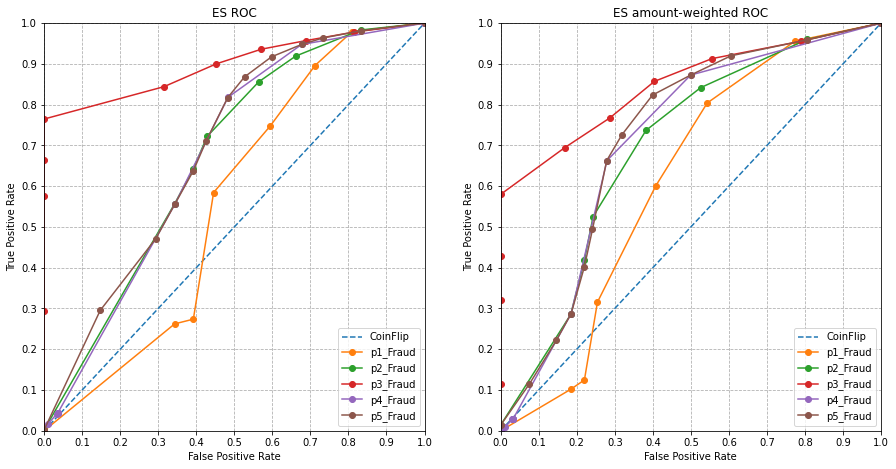

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7.5))

prepare_axes(ax1, 'ES ROC', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax1, rcrows[0::2], rcrows[1::2], systems, marker='o')
prepare_axes(ax2, 'ES amount-weighted ROC', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax2, wrcrows[0::2], wrcrows[1::2], systems, marker='o')

## Задание 4

Определим значения отсечки с шагом 0.01. Поскольку предстоит строить ROC - заранее включеним 0 и 1:

In [23]:
precise_cutoffs = [0.01 * i for i in range(101)]

Аналогичным заданию 3 образом подсчитаем FPR/TPR:

In [24]:
pr_rc = lambda s: roc_descr(s, table.data[s], table.data['CLASS'], precise_cutoffs)

pr_rcrows = list(unfold(map(pr_rc, systems), 2))

pr_wrc = lambda s: roc_descr(s, table.data[s], table.data['CLASS'], precise_cutoffs, table.data['AMOUNT'])

pr_wrcrows = list(unfold(map(pr_wrc, systems), 2))

И построим ROC-кривые:

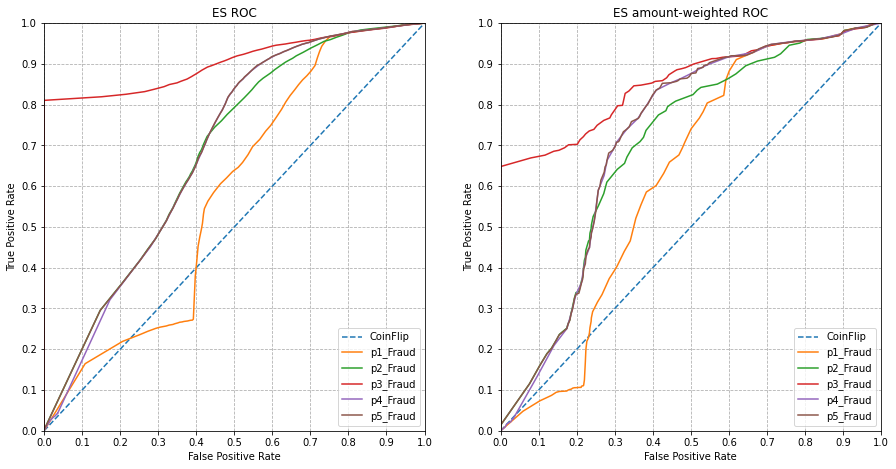

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7.5))

prepare_axes(ax1, 'ES ROC', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax1, pr_rcrows[0::2], pr_rcrows[1::2], systems)
prepare_axes(ax2, 'ES amount-weighted ROC', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax2, pr_wrcrows[0::2], pr_wrcrows[1::2], systems)

## Задание 5

Определим функцию, которая строит кривую precision-recall аналогично таковой для ROC:

In [26]:
def plot_pr(axes, xdata, ydata, labels, **kwargs):
    for x, y in zip(xdata, ydata):
        axes.plot(x[1:], y[1:], **kwargs)
    axes.legend(labels, loc="upper right")

Построим precision-recall кривые:

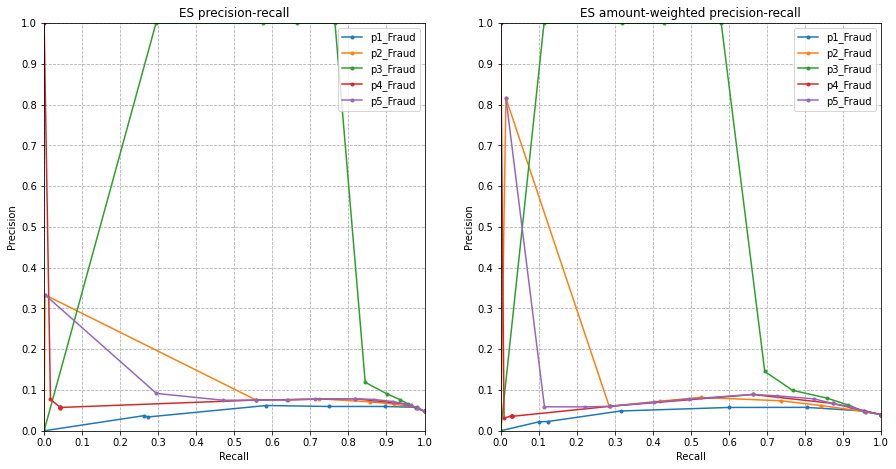

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7.5))

prepare_axes(ax1, 'ES precision-recall', 'Recall', 'Precision')
plot_pr(ax1, rows[0::2], rows[1::2], systems, marker='.')
prepare_axes(ax2, 'ES amount-weighted precision-recall', 'Recall', 'Precision')
plot_pr(ax2, wrows[0::2], wrows[1::2], systems, marker='.')

## Задание 6

Сконструируем таблицы из всех полученных данных и импортируем их в CSV:

In [28]:
cutoff_columns = ['system'] + cutoffs
precise_cutoff_columns = ['system'] + precise_cutoffs

Table(cutoff_columns, rows).to_csv('prec_recl_unweighted.csv')
Table(cutoff_columns, wrows).to_csv('prec_recl_weighted.csv')
Table(cutoff_columns, rcrows).to_csv('roc_unweighted.csv')
Table(cutoff_columns, wrcrows).to_csv('roc_weighted.csv')
Table(precise_cutoff_columns, pr_rcrows).to_csv('precise_roc_unweighted.csv')
Table(precise_cutoff_columns, pr_wrcrows).to_csv('precise_roc_weighted.csv')

## Задание 7

$$p =\frac{A \cdot p1\_Fraud + B \cdot p2\_Fraud + C \cdot p3\_Fraud}{A + B + C}$$

Значение нормируется относительно весов. То есть важны нестолько величина значений, сколько отношение между ними. Судя по графикам, максимальный AUC/Gini у p3_Fraud, а минимальный у p1_Fraud. Крайне сомнительно, что есть такие A, B, C с которыми ансамбль будет работать лучше чем p3 и хуже чем p1. Подтвердить это можно аналитически (при помощи любого алгоритма многокритериальной оптимизации, который может работать с метрикой gini как с функцией ошибки), или переборно. Даже если перебрать по 10 значений для каждого параметра, то общая картина уже должна будет сложиться. К тому же, перебор можно "собрать" из того что есть с минимальными доработками.

Определим пачку вспомогательных функций:
- AUC - площадь под кривой. Посчитать довольно просто, если вспомнить геометрию за 5 класс. Больше точек - выше точность.
- gini - сам коэффициент Джини
- prev_current - вспомогательная функция, которая в одной итерации возвращает как текущее, так и предыдущее значение последовтельности

In [29]:
def prev_current(it: Iterable):
    prev = next(it)
    for current in it:
        yield prev, current
        prev = current


def auc(xy_pairs):
    area = 0
    for (x0, y0), (x1, y1) in prev_current(iter(xy_pairs)):
        b = x1 - x0
        if b: area += (y0 + y1) * b / 2
    return area


def gini(xy_pairs):
    return abs((auc(xy_pairs) - 0.5) / 0.5)

Следующие функции реализуют вычисление fpr_tpr для переданных значений весов на наборах ответов систем и действительных меток, а так же вычисление коэффициента Джини системы по результату предыдущуей функции. Последняя функция так же "разворачивает" последовательность, потому что порядок следования элементов важен для AUC, а после fpr_tpr элементы располагаются в обратом порядке:

In [30]:
from itertools import product


def minmax(it: Iterable):
    mn, mnp = mx, mxp = next(it)
    for val, pkg in it:
        if val < mn: mn, mnp = val, pkg
        if val > mx: mx, mxp = val, pkg
    return (mn, mnp), (mx, mxp)


def ensemble_descr(xtrain, ytrain, params, cutoffs, weights=None):
    s = sum(params)
    scores = [sum(x * p for x, p in zip(xt, params)) / s for xt in xtrain]
    return describe_system(fpr_tpr, scores, ytrain, cutoffs, weights)


def gini_loss(*args, **kwargs):
    return gini(reversed(ensemble_descr(*args, **kwargs)))

Определим отсечки и сформируем данные:

In [31]:
train_cutoffs = [0.1 * i for i in range(11)]


ytrain = table.data['CLASS']
xtrain = list(transpose([table.data[col] for col in ['p1_Fraud', 'p2_Fraud', 'p3_Fraud']]))

Выполним сами расчеты:

In [32]:
weights = product(range(0, 11), range(0, 11), range(0, 11))
next(weights)
zmn, zmx = minmax(map(lambda w: (gini_loss(xtrain, ytrain, w, train_cutoffs), w), weights))
print(f"Minimum gini: {zmn[0]} with weights {zmn[1]}")
print(f"Maximum gini: {zmx[0]} with weights {zmx[1]}")

Minimum gini: 0.1133509633626053 with weights (1, 0, 0)
Maximum gini: 0.7972815313206523 with weights (0, 0, 1)


Подготовим данные для вывода графика и построим его на них:

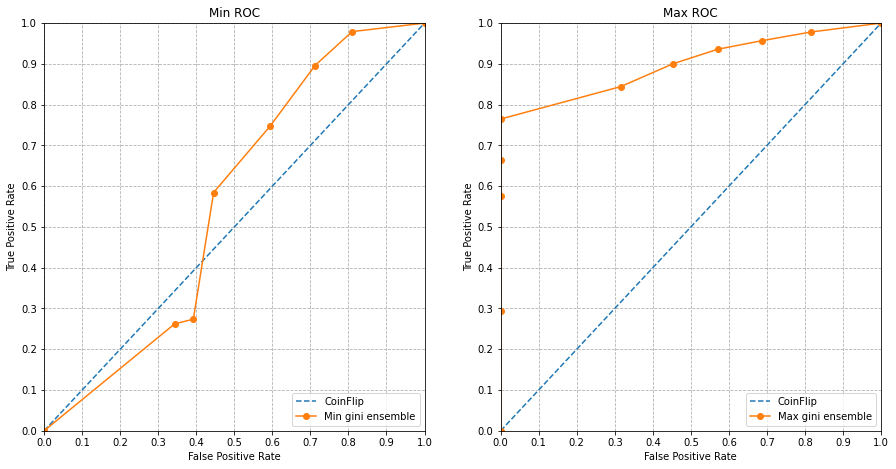

In [33]:
minsys = list(transpose(ensemble_descr(xtrain, ytrain, zmn[1], train_cutoffs)))
maxsys = list(transpose(ensemble_descr(xtrain, ytrain, zmx[1], train_cutoffs)))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7.5))

prepare_axes(ax1, 'Min ROC', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax1, [minsys[0]], [minsys[1]], ['Min gini ensemble'], named=False, marker='o')
prepare_axes(ax2, 'Max ROC', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax2, [maxsys[0]], [maxsys[1]], ['Max gini ensemble'], named=False, marker='o')

Аналогично для взвешенных значений:

In [34]:
weights = product(range(0, 11), range(0, 11), range(0, 11))
next(weights)
wmn, wmx = minmax(map(lambda w: (gini_loss(xtrain, ytrain, w, train_cutoffs, table.data['AMOUNT']), w), weights))
print(f"Minimum gini: {wmn[0]} with weights {wmn[1]}")
print(f"Maximum gini: {wmx[0]} with weights {wmx[1]}")

Minimum gini: 0.2209257726852505 with weights (1, 0, 0)
Maximum gini: 0.6950124521876448 with weights (0, 0, 1)


Получаем графики:

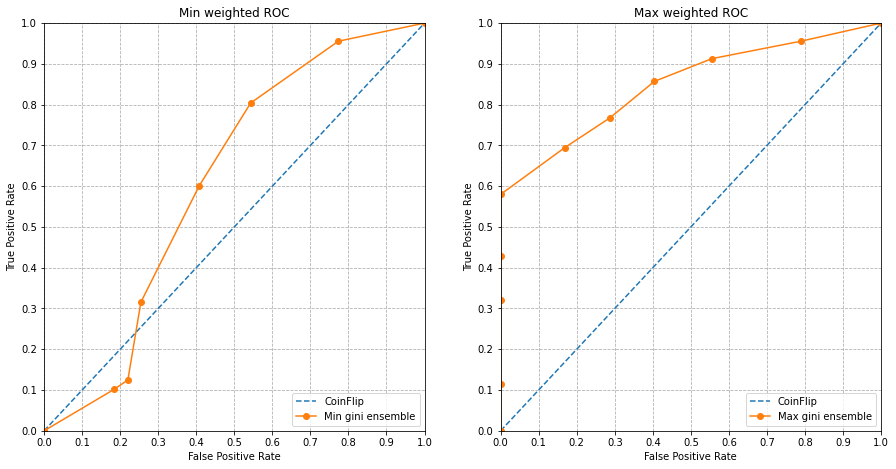

In [35]:
wminsys = list(transpose(ensemble_descr(xtrain, ytrain, wmn[1], train_cutoffs, table.data['AMOUNT'])))
wmaxsys = list(transpose(ensemble_descr(xtrain, ytrain, wmx[1], train_cutoffs, table.data['AMOUNT'])))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7.5))

prepare_axes(ax1, 'Min weighted ROC', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax1, [wminsys[0]], [wminsys[1]], ['Min gini ensemble'], named=False, marker='o')
prepare_axes(ax2, 'Max weighted ROC', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax2, [wmaxsys[0]], [wmaxsys[1]], ['Max gini ensemble'], named=False, marker='o')

Судя по полученным результатам, с опеределенной долей уверенности можно сказать, что предположения выдвинутые в начале были верны. Тем не менее, найдем веса при помощи какого-нибудь метода многокритериальной оптимизации (тем более, что задание 7.3 уже так не сделаешь, похоже). Пусть это будут генетические алгоритмы.

Адаптируем код из [моего репозитория на GH](https://github.com/mocurin/tsisa_lab04/blob/master/genetic_algorithm.py) чтобы исключить использование numpy & pandas. Реализуем "околотурнирую" селекцию - будем оставлять лучшие особи и их детей, тем самым удваивая популяцию на каждом поколении. Чтобы удвоения не происходило - скрещивать будем лишь половину особей. "Невариабельность" в вопросах размножения компенсируем малым шагом и высокой вероятностью мутации:

In [38]:
import random as rd
from itertools import starmap
from functools import reduce


def group(it: Iterable, n: int):
    args = [iter(it)] * n
    return zip(*args)


def argsort(l: List):
    return sorted(range(len(l)),
                  key=lambda idx: l[idx])

def rearange(l: List, indices: List[int]):
    return [l[idx] for idx in indices]


def roll(p):
    return rd.uniform(0, 1) < p


def switch_check(delta, element, bounds):
    return element + delta > bounds[0] if delta < 0 else element + delta < bounds[1]


class GeneticAlgorithm:
    def __init__(self, mut_step, mut_prob,
                 population, verbose=True):
        self._mut_step = mut_step
        self._mut_prob = mut_prob
        self._population = population
        self._verbose = verbose
        self._function = None
        if verbose:
            print(f"Population of {population} species. "
                  f"Mutation step: {mut_step}. "
                  f"Mutation probability: {mut_prob}")

    def __call__(self, function, bounds, generations, seed=42):
        rd.seed(seed)
        self._pops = []
        self._function = function
        population = self._init_population(bounds)
        for idx in range(generations):
            self._gen = idx
            population = reduce(lambda x, y: y(x), [population,
                                                    self._selector,
                                                    self._crossover,
                                                    self._mutator])
            
        return self._pops

    def _selector(self, population):
        scores = self._score(population)
        indices = list(argsort(scores))[:-(len(population) // 2 + 1):-1]
        population = rearange(population, indices)
        scores = rearange(scores, indices)
        if self._verbose:
            print(f"Gen {self._gen:<2} "
                  f"TopSCR {scores[0]:.3f} "
                  f"TopSPEC {population[0]}")
        self._pops.append((population, scores))
        return population

    def _crossover(self, population):
        parents = [(spec1, spec2, rd.randrange(1, len(spec1)))
                   for spec1, spec2 in group(population, 2)]
        return list(unfold(([spec1, spec2,
                             spec2[idx:] + spec1[:idx],
                             spec1[idx:] + spec2[:idx]]
                            for spec1, spec2, idx in parents), 2))

    def _mutator(self, population):
        return [list(map(self._roll_mutation_step, genes))
                for genes in population]

    def _init_population(self, bounds):
        return [list(starmap(rd.uniform, bounds))
                for _ in range(self._population)]

    def _score(self, population):
        return list(map(self._function, population))
    
    def _roll_mutation_step(self, elem):
        return elem + self._mut_step * (-1 if roll(0.5) else 1) if roll(self._mut_prob) else elem

Запустим GA для поиска максимума:

In [39]:
ga = GeneticAlgorithm(0.1, 0.25, 12)
loss = lambda w: gini_loss(xtrain, ytrain, w, train_cutoffs)
max_pops = ga(loss,
              bounds=[[0., 1.], [0., 1.], [0., 1.]],
              generations=100)

Population of 12 species. Mutation step: 0.1. Mutation probability: 0.25
Gen 0  TopSCR 0.726 TopSPEC [0.026535969683863625, 0.1988376506866485, 0.6498844377795232]
Gen 1  TopSCR 0.780 TopSPEC [-0.07346403031613638, 0.1988376506866485, 0.5498844377795232]
Gen 2  TopSCR 0.797 TopSPEC [-0.07346403031613638, 0.09883765068664849, 0.5498844377795232]
Gen 3  TopSCR 0.797 TopSPEC [-0.07346403031613638, 0.09883765068664849, 0.5498844377795232]
Gen 4  TopSCR 0.797 TopSPEC [-0.07346403031613638, 0.09883765068664849, 0.5498844377795232]
Gen 5  TopSCR 0.822 TopSPEC [-0.07346403031613638, -0.0011623493133515184, 0.5498844377795232]
Gen 6  TopSCR 0.772 TopSPEC [-0.07020278056192966, 0.21863797480360336, 0.6053552881033624]
Gen 7  TopSCR 0.780 TopSPEC [-0.07346403031613638, -0.10116234931335152, 0.5498844377795232]
Gen 8  TopSCR 0.791 TopSPEC [0.026535969683863625, -0.10116234931335152, 0.5498844377795232]
Gen 9  TopSCR 0.791 TopSPEC [0.026535969683863625, -0.10116234931335152, 0.5498844377795232]
Gen

Gen 90 TopSCR 0.850 TopSPEC [-0.27678926185117725, 0.03647121416401258, 0.6037260313668911]
Gen 91 TopSCR 0.850 TopSPEC [-0.27678926185117725, 0.03647121416401258, 0.6037260313668911]
Gen 92 TopSCR 0.852 TopSPEC [0.03647121416401258, 0.6037260313668911, -0.4767892618511772]
Gen 93 TopSCR 0.961 TopSPEC [0.703726031366891, -0.4767892618511772, -0.17678926185117724]
Gen 94 TopSCR 0.961 TopSPEC [0.703726031366891, -0.4767892618511772, -0.17678926185117724]
Gen 95 TopSCR 0.952 TopSPEC [-0.07678926185117724, -0.07678926185117724, 0.1364712141640126]
Gen 96 TopSCR 0.952 TopSPEC [-0.07678926185117724, -0.07678926185117724, 0.1364712141640126]
Gen 97 TopSCR 0.952 TopSPEC [-0.07678926185117724, -0.07678926185117724, 0.1364712141640126]
Gen 98 TopSCR 0.837 TopSPEC [-0.17678926185117724, 0.03647121416401258, 0.6037260313668911]
Gen 99 TopSCR 0.837 TopSPEC [-0.17678926185117724, 0.03647121416401258, 0.6037260313668911]


А так же для поиска минимума:

In [40]:
ga = GeneticAlgorithm(0.1, 0.25, 12)
loss = lambda w: 1 - gini_loss(xtrain, ytrain, w, train_cutoffs)
min_pops = ga(loss,
              bounds=[[0., 1.], [0., 1.], [0., 1.]],
              generations=100)

Population of 12 species. Mutation step: 0.1. Mutation probability: 0.25
Gen 0  TopSCR 0.780 TopSPEC [0.9572130722067812, 0.33659454511262676, 0.09274584338014791]
Gen 1  TopSCR 0.824 TopSPEC [0.8572130722067812, 0.33659454511262676, -0.007254156619852098]
Gen 2  TopSCR 0.822 TopSPEC [0.8572130722067812, 0.23659454511262676, -0.007254156619852098]
Gen 3  TopSCR 0.822 TopSPEC [0.8572130722067812, 0.23659454511262676, -0.007254156619852098]
Gen 4  TopSCR 0.822 TopSPEC [0.8572130722067812, 0.23659454511262676, -0.007254156619852098]
Gen 5  TopSCR 0.827 TopSPEC [0.8572130722067812, 0.13659454511262675, -0.007254156619852098]
Gen 6  TopSCR 0.993 TopSPEC [0.8572130722067812, 0.03659454511262675, -0.1072541566198521]
Gen 7  TopSCR 0.993 TopSPEC [0.8572130722067812, 0.03659454511262675, -0.1072541566198521]
Gen 8  TopSCR 0.983 TopSPEC [0.9572130722067812, 0.03659454511262675, -0.1072541566198521]
Gen 9  TopSCR 0.983 TopSPEC [0.9572130722067812, 0.03659454511262675, -0.1072541566198521]
Gen 10 

Gen 90 TopSCR 0.967 TopSPEC [0.12501075522266697, 1.1394267984578839, -0.3749892447773331]
Gen 91 TopSCR 0.996 TopSPEC [1.239426798457884, -0.3749892447773331, 0.12501075522266697]
Gen 92 TopSCR 0.949 TopSPEC [0.12501075522266697, 1.239426798457884, -0.3749892447773331]
Gen 93 TopSCR 0.977 TopSPEC [-0.1749892447773331, 1.239426798457884, -0.3749892447773331]
Gen 94 TopSCR 0.977 TopSPEC [-0.1749892447773331, 1.239426798457884, -0.3749892447773331]
Gen 95 TopSCR 0.967 TopSPEC [0.12501075522266697, 1.1394267984578839, -0.3749892447773331]
Gen 96 TopSCR 0.989 TopSPEC [-0.0749892447773331, 1.1394267984578839, -0.3749892447773331]
Gen 97 TopSCR 0.989 TopSPEC [-0.0749892447773331, 1.1394267984578839, -0.3749892447773331]
Gen 98 TopSCR 0.987 TopSPEC [-0.0749892447773331, 1.0394267984578838, -0.3749892447773331]
Gen 99 TopSCR 0.987 TopSPEC [-0.0749892447773331, 1.0394267984578838, -0.3749892447773331]


О том чтобы брать отрицательные значения я не задумывался. И так бы их и не проверил, если бы не поленился в ограничивать область поиска в операторе мутации. 

Построим ROC для полученных весов:

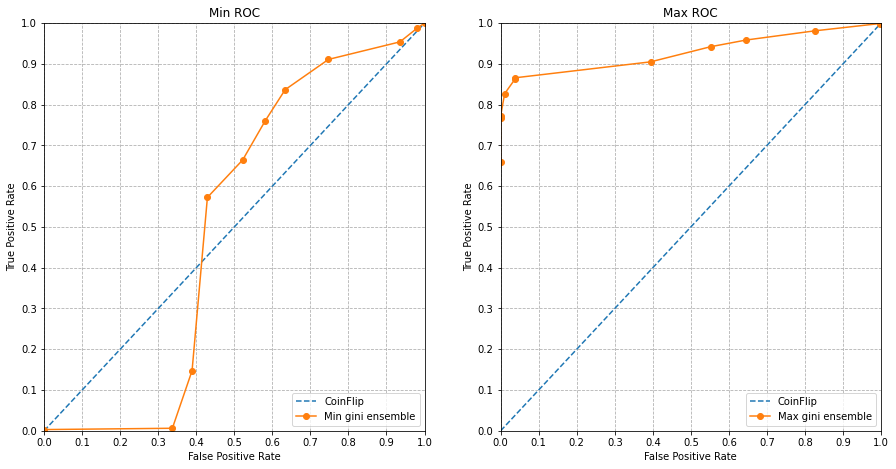

In [43]:
minsys = list(transpose(ensemble_descr(xtrain, ytrain, [-0.1749892447773331,
                                                        1.1394267984578839,
                                                        -0.3749892447773331],
                                       train_cutoffs)))
maxsys = list(transpose(ensemble_descr(xtrain, ytrain, [-0.27678926185117725,
                                                        0.03647121416401258,
                                                        0.6037260313668911],
                                       train_cutoffs)))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7.5))

prepare_axes(ax1, 'Min ROC', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax1, [minsys[0]], [minsys[1]], ['Min gini ensemble'], named=False, marker='o')
prepare_axes(ax2, 'Max ROC', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax2, [maxsys[0]], [maxsys[1]], ['Max gini ensemble'], named=False, marker='o')

Кривые выглядят довольно правдоподобно.
Но я не взял значения, дающие максимальный к. Джини - на них ROC получается "сломанной":

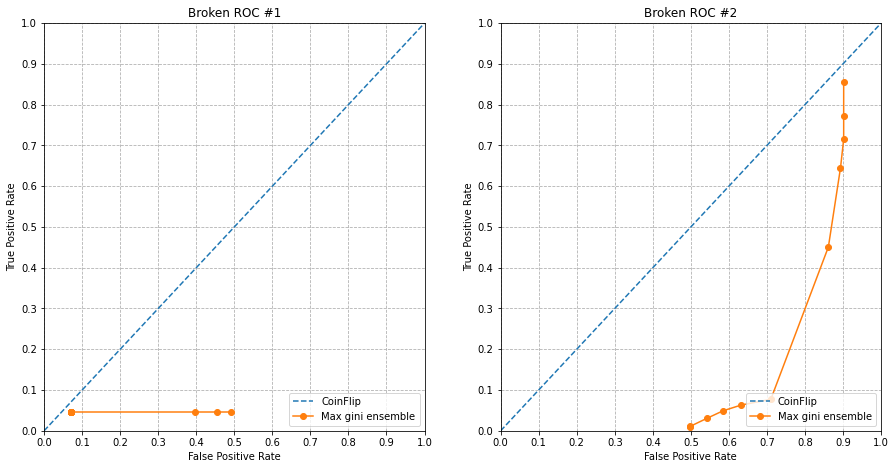

In [42]:
minsys = list(transpose(ensemble_descr(xtrain, ytrain, [0.703726031366891,
                                                        -0.4767892618511772,
                                                        -0.17678926185117724],
                                       train_cutoffs)))
maxsys = list(transpose(ensemble_descr(xtrain, ytrain, [0.03647121416401258,
                                                        0.6037260313668911,
                                                        -0.4767892618511772],
                                       train_cutoffs)))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7.5))

prepare_axes(ax1, 'Broken ROC #1', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax1, [minsys[0]], [minsys[1]], ['Max gini ensemble'], named=False, marker='o')
prepare_axes(ax2, 'Broken ROC #2', 'False Positive Rate', 'True Positive Rate')
plot_roc(ax2, [maxsys[0]], [maxsys[1]], ['Max gini ensemble'], named=False, marker='o')

Я подозреваю, что это ошибка где-то в районе подсчета метрик. Кажется, GA зачем-то стремится занулить сумму весов. Поэтому, если бы у меня было время, я бы начал проверку с функций `auc`/`gini`/`descr_ensemble`.